In [43]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd

data = pd.read_csv('coag.csv')

diet_to_idx = {v:k for k, v in enumerate(data['Diet'].unique())}
data['Diet'] = data['Diet'].map(diet_to_idx)

In [44]:
data.head()

,Diet,Measurements
0,0,62
1,0,60
2,0,63
3,0,59
4,1,63


We want to model this data. Each observation is a coagulation time (seconds) for an animal on a particular diet.

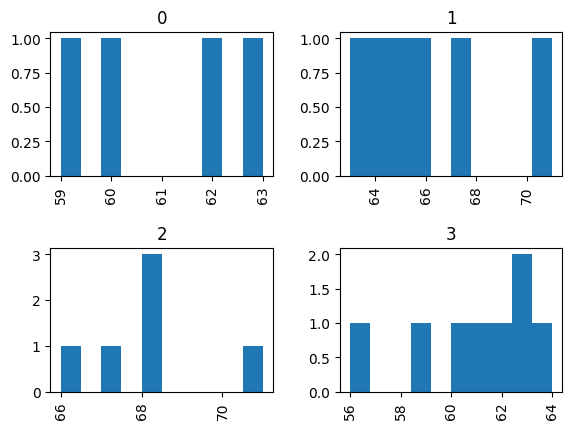

In [45]:
data.hist(column='Measurements', by='Diet')
plt.show()

We can try a hierarchical normal model, whereby the measurements are normally distributed within each group:

\begin{align*}
    \theta_j & \sim \mathcal{N}\left(\mu, \tau^2\right), \;j=1,2,3,4 \\
    y_{ij} & \sim \mathcal{N}\left(\theta_j, \sigma^2\right), \; j=1,2,3,4,\, i=1\ldots,n_j \\
    \mu, \log\sigma, \tau & \sim \text{Uniform}
\end{align*}

The posterior distribution is thus

$$ p\left(\theta_{1:4}, \mu, \log\sigma, \log \tau \, \middle|\, y_{ij}\right) \propto \tau \prod_{j=1}^4 N\left(\theta_j\,\middle|\,\mu, \tau^2\right) \prod_{j=1}^4 \prod_{i=1}^{n_j} N\left(y_{ij}\,\middle|\,\theta_j,\sigma^2\right)$$

## Gibbs sampler

We will first try to sample the posterior by the Gibbs sampling algorithm. As usual, we need to construct the complete conditional distributions for the parameters.

Up to additive constants, we have

\begin{align*}
    \log p\left(\theta_j \,\middle|\, \cdot\right) & = \log N\left(\theta_j\,\middle|\,\mu,\tau^2\right) +\sum_{i=1}^{n_j} \log N\left(y_{ij}\, \middle| \, \theta_j, \sigma^2\right) \\
    & = -\frac{1}{2\tau^2}\left(\theta_j - \mu\right)^2 - \frac{1}{2\sigma^2}\sum_{i=1}^{n_j} \left(y_{ij}-\theta_j\right)^2  \\
    & = -\frac{1}{2\tau^2}\left[\theta_j^2 - 2\mu\theta_j\right] - \frac{1}{2\sigma^2}\sum_{i=1}^{n_j} \left[-2y_{ij}\theta_j + \theta_j^2\right] \\
    & = -\frac{1}{2\tau^2}\left[\theta_j^2 - 2\mu\theta_j\right] - \frac{1}{2\sigma^2}\left[ -2\theta_j \sum_{i=1}^{n_j} y_{ij} + n_j\theta_j^2\right] \\
    & = -\frac{1}{2\tau^2\sigma^2}\left[ \sigma^2\theta_j^2 - 2\mu\sigma^2\theta_j - 2\tau^2\theta_j n_j\bar{y}_j +\tau^2 n_j \theta_j^2\right] \\
    & = -\frac{1}{2\tau^2\sigma^2}\left[ \left(\sigma^2 + \tau^2n_j\right)\theta_j^2 - 2\left(\mu\sigma^2 + \tau^2n_j\bar{y}_j\right)\theta_j\right] \\
    & = -\frac{\sigma^2 + \tau^2n_j}{2\tau^2\sigma^2}\left[ \theta_j^2 - 2\frac{\left(\mu\sigma^2 + \tau^2n_j\bar{y}_j\right)}{\sigma^2 + \tau^2n_j}\theta_j\right] \\
    & = -\frac{1}{2V_{\theta_j}} \left(\theta_j - \hat{\theta}_j \right)^2 \\
\end{align*}

where

$$ \hat{\theta}_j = \frac{\mu\sigma^2 + \tau^2n_j\bar{y}_j}{\sigma^2 + \tau^2n_j} = \frac{\mu/\tau^2 + n_j\bar{y}_j/\sigma^2}{1/\tau^2 + n_j/\sigma^2} $$

and

$$ V_{\theta_j} = \frac{\sigma^2\tau^2}{\sigma^2 + \tau^2n_j} = \frac{1}{1/\tau^2 + n_j / \sigma^2}$$

In [46]:
# sample theta_j

data_bar = data.groupby(by='Diet')

j = 0

y_bar_j = data_bar.mean().loc[j, 'Measurements']
n_j = data_bar.count().loc[j, 'Measurements']
mu = 1.0
sigma2 = 1.0
tau2 = 1.0

theta_j_hat = ( mu/tau2 + n_j * y_bar_j/sigma2) / ((1/tau2) + n_j / sigma2)
var_j_hat = 1/((1/tau2) + n_j/sigma2)

ss.norm(loc=theta_j_hat, scale=np.sqrt(var_j_hat)).rvs()

48.17405592993922

For the hyperparameter $\mu$ we have, up to additive constants, 

\begin{align*}
    \log p\left(\mu\,\middle|\,\cdot\right) & = \sum_{j=1}^4 \log N\left(\theta_j\,\middle|\,\mu,\tau^2\right) \\
     & = -\frac{1}{2\tau^2}\sum_{j=1}^4\left(\theta_j-\mu\right)^2 \\
     & = -\frac{1}{2\tau^2} \sum_{j=1}^4 \left[\theta_j^2 - 2\theta_j\mu + \mu^2\right] \\
     & = -\frac{1}{2\tau^2} 4\left[\mu^2 - \frac{2}{4}\mu \sum_{j=1}^4 \theta_j \right]\\
     & = -\frac{1}{2\frac{\tau^2}{4}} \left(\mu - \frac{1}{4}\sum_{j=1}^4\theta_j \right)^2\\
\end{align*}



so that $$ \mu \,| \, \cdot \sim \mathcal{N}\left( \frac{1}{J}\sum_{j=1}^J \theta_j, \frac{1}{J}\tau^2 \right) $$

In [53]:
# sample mu
theta_j = ss.norm(60.0, 10.0).rvs(4)
J = len(theta_j)

ss.norm(loc=theta_j.mean(), scale=np.sqrt(tau2/J)).rvs()



57.27807100295993

The posterior distribution is thus

$$ p\left(\theta_{1:4}, \mu, \log\sigma, \log \tau \, \middle|\, y_{ij}\right) \propto \tau \prod_{j=1}^4 N\left(\theta_j\,\middle|\,\mu, \tau^2\right) \prod_{j=1}^4 \prod_{i=1}^{n_j} N\left(y_{ij}\,\middle|\,\theta_j,\sigma^2\right)$$

The complete conditional for $\sigma^2$ is, up to additive constants,

\begin{align*}
    \log p\left(\sigma^2\,\middle|\,\cdot\right) & = \sum_{j=1}^4 \sum_{i=1}^{n_j} \log N\left(y_{ij}\,\middle|\, \theta_j,\sigma^2\right) \\
    & = -\frac{1}{2\sigma^2} \sum_{j=1}^4 \sum_{i=1}^{n_j} \left(y_{ij} - \theta_j\right)^2 \\
\end{align*}

This shows that $\sigma^2$ is distributed as a variance of a normal distribution. From the wikipedia article,

>the inverse-chi-squared distribution...can be used as the prior and posterior distribution for an unknown variance of the normal distribution.

$$ \sigma^2 | \cdot \sim \text{Inv}_{\chi^2} \left(n, \hat{\sigma}^2\right) $$

where $$ n = \sum_{j=1}^J n_j$$

and $$ \hat{\sigma}^2 = \frac{1}{n}\sum_{j=1}^J \sum_{i=1}^{n_j} \left(y_{ij} - \theta_j\right)^2 $$

In [64]:
n = data.shape[0]
sigma2_hat = np.sum((data['Measurements'] - theta_j[data['Diet']])**2) / n

ss.chi2(n, sigma2_hat).rvs()


256.38642595206454

Similarly, the complete conditional for $\tau^2$ is 

$$ \tau^2\,| \, \cdot \sim \text{Inv-}\chi^2 \left(J-1, \hat{\tau}^2\right) $$

where

$$ \hat{\tau}^2 = \frac{1}{J-1} \sum_{j=1}^J \left(\theta_j-\mu\right)^2 $$

In [157]:
theta_j = 60.0 * np.ones(4)

data_bar = data.groupby(by='Diet')
y_bar_j = data_bar['Measurements'].mean().values
n_j = data_bar['Measurements'].count().values

mu = 60.0
sigma2 = 2.0**2
tau2 = 4.0**2

def sample_theta(mu, sigma2, tau2):
    theta_j_hat = ( mu/tau2 + n_j * y_bar_j/sigma2) / ((1/tau2) + n_j / sigma2)
    var_j_hat = 1/((1/tau2) + n_j/sigma2)

    theta_j_new = np.array([
        ss.norm(loc=theta_j_hat[j], scale=np.sqrt(var_j_hat[j])).rvs()
        for j in range(len(theta_j_hat))
    ])
    return theta_j_new


def sample_mu(theta_j, tau2):
    J = len(theta_j)
    return ss.norm(loc=theta_j.mean(), scale=np.sqrt(tau2/J)).rvs()




In [158]:
def _sample_sics(dof, scale):
    """Sample a scaled-inverse-chi-squared distribution."""
    z = ss.uniform.rvs()
    return ss.chi2(df=dof, scale=scale).ppf(z)

def sample_sigma2(n_j, data, theta_j):
    n = np.sum(n_j)
    sigma2_hat = np.sum((data['Measurements'] - theta_j[data['Diet']]).values**2) / np.sum(n_j)

    return _sample_sics(dof=n, scale=np.sqrt(sigma2_hat))

def sample_tau2(n_j, theta_j, mu):
    J = len(n_j)
    tau2_hat = np.sum((theta_j - mu)**2) / (J-1)

    return _sample_sics(dof=J-1, scale=np.sqrt(tau2_hat))

In [205]:
history = dict()
n_iters_per_chain = 100
nc = 10

def init_hist_chain(nipc):
    return {
    "theta": np.zeros((nipc, 4)),
    "mu": np.zeros(nipc),
    "sigma2": np.zeros(nipc),
    "tau2": np.zeros(nipc),
}
history = {c_idx: init_hist_chain(n_iters_per_chain) for c_idx in range(nc)}

In [206]:
for c_idx in range(nc):
    theta_j = ss.norm(60.0, 10.0).rvs(4)
    mu = ss.norm(60.0,3.0).rvs()
    sigma2 = ss.norm(2.0, 0.2).rvs()**2
    tai2 = ss.norm(5.0, 0.5).rvs()**2

    for n in range(n_iters_per_chain):
        theta_j = sample_theta(mu, sigma2, tau2)
        mu = sample_mu(theta_j, tau2)
        sigma2 = sample_sigma2(n_j, data, theta_j)
        tau2 = sample_tau2(n_j, theta_j, mu)

        history[c_idx]['theta'][n] = theta_j
        history[c_idx]['mu'][n] = mu
        history[c_idx]['sigma2'][n] = sigma2
        history[c_idx]['tau2'][n] = tau2

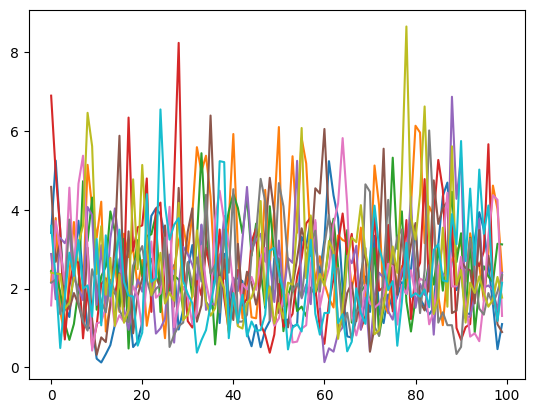

In [215]:
burn_in = 200

fig, ax = plt.subplots()

for c_idx in range(nc):
    c_p = np.sqrt(history[c_idx]['tau2'])
    # c_p = history[c_idx]['theta'][:,0]
    ax.plot(c_p)

plt.show()

In [208]:
mus = np.concatenate([history[c_idx]['mu'] for c_idx in range(nc)])
np.quantile(a=mus, q=[0.025, 0.25, 0.5, 0.75, 0.975])

array([58.5422581 , 62.44833049, 63.96366389, 65.38672161, 68.45926506])

In [210]:

sigmas = np.sqrt(np.concatenate([history[c_idx]['sigma2'] for c_idx in range(nc)]))
np.quantile(a=sigmas, q=[0.025, 0.25, 0.5, 0.75, 0.975])

array([ 6.45793506,  8.29305108,  9.41895071, 10.67004788, 13.94478846])

In [213]:
taus = np.sqrt(np.concatenate([history[c_idx]['tau2'] for c_idx in range(nc)]))
np.quantile(a=taus, q=[0.025, 0.25, 0.5, 0.75, 0.975])

array([0.54989702, 1.52429968, 2.22360431, 3.17739935, 5.44020867])